Declare Imports

In [76]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import os
import cv2
import matplotlib.pyplot as plt
import PIL.Image as img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from os import walk

Initialize dataset

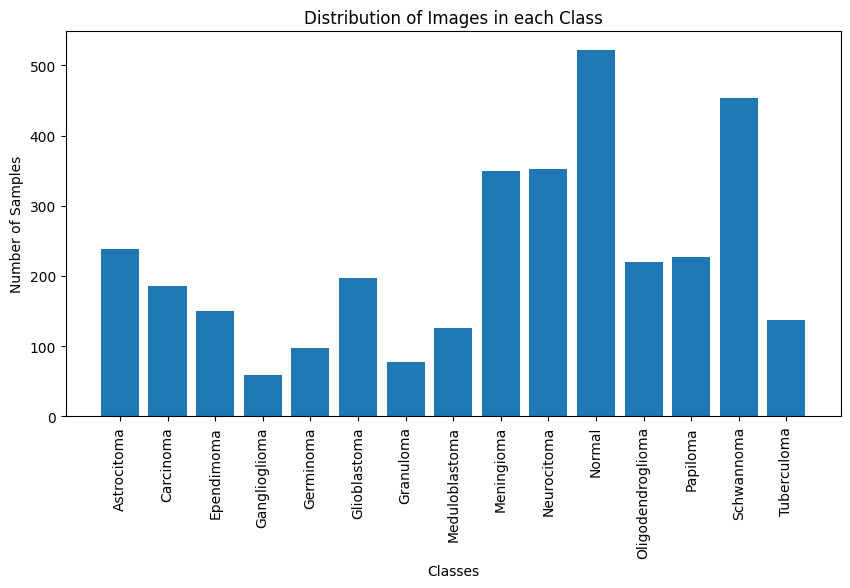

Found 3394 files belonging to 15 classes.
Using 2376 files for training.
Found 3394 files belonging to 15 classes.
Using 1018 files for validation.


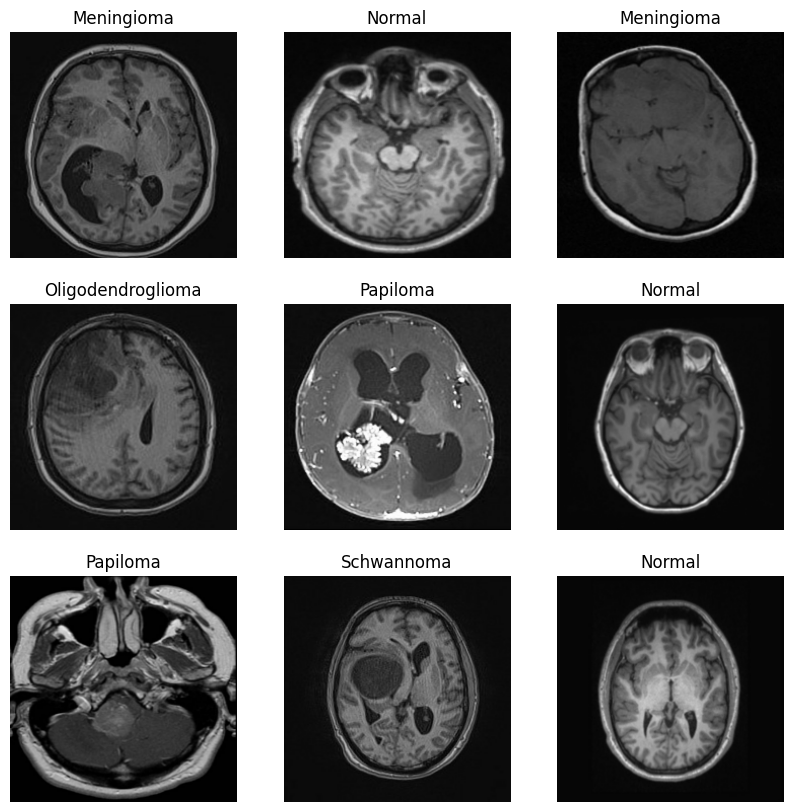

In [86]:
brain_tumor_dataset = r'C:\Users\Hamzah\Desktop\COMP 445\Brain Tumors Dataset'

image_size = (224, 224)
batch_size = 32

# Get all image classes and number of images in each class
classes = os.listdir(brain_tumor_dataset)
num_images = []
for c in classes:
    num_images.append(len(os.listdir(os.path.join(brain_tumor_dataset, c))))

# Plot the number of images in each class
plt.figure(figsize=(10, 5))
plt.bar(classes, num_images)
plt.title('Distribution of Images in each Class')
plt.xlabel('Classes')

# Rotate the x-axis labels
plt.xticks(rotation=90)

plt.ylabel('Number of Samples')
plt.show()

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    brain_tumor_dataset,
    validation_split=0.3,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    brain_tumor_dataset,
    validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

#Plot the images in the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")

Data preparation & pre-processing

0.00054664613 0.9459906


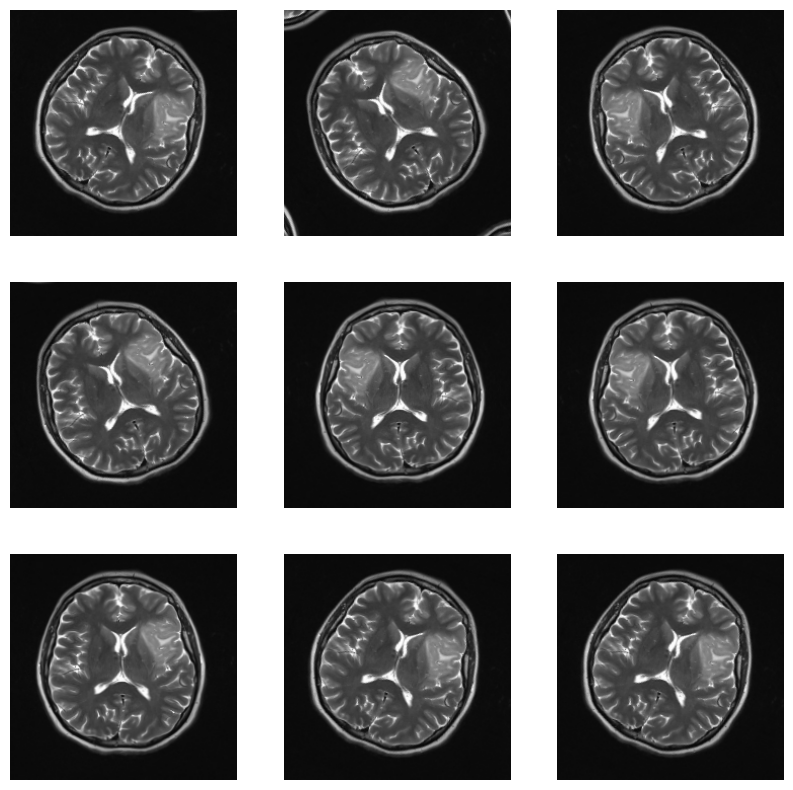

In [87]:
#Resizing the images
IMG_SIZE = 224
def resize_image(image):
    return tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

train_ds = train_ds.map(lambda x, y: (resize_image(x), y))
val_ds = val_ds.map(lambda x, y: (resize_image(x), y))

#Normalizing the images
normalization_layer = preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

#Data Augmentation
data_augmentation = tf.keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.1),
    ]
)

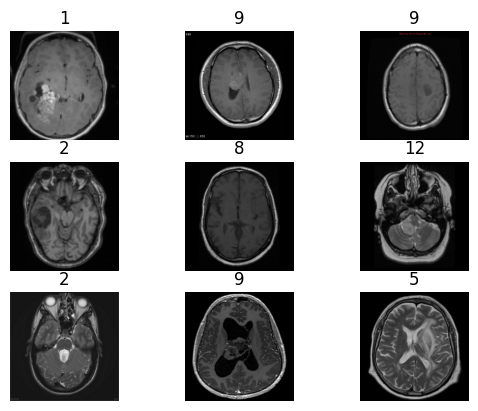

In [79]:
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Training VGG19 Model

Epoch 1/10
75/75 [==============================] - 246s 3s/step - loss: 2.9276 - accuracy: 0.2778 - val_loss: 1.6611 - val_accuracy: 0.5678
Epoch 2/10
75/75 [==============================] - 235s 3s/step - loss: 1.8104 - accuracy: 0.4537 - val_loss: 1.3747 - val_accuracy: 0.5982
Epoch 3/10
75/75 [==============================] - 253s 3s/step - loss: 1.5072 - accuracy: 0.5404 - val_loss: 1.2103 - val_accuracy: 0.6434
Epoch 4/10
75/75 [==============================] - 248s 3s/step - loss: 1.3469 - accuracy: 0.5850 - val_loss: 1.0776 - val_accuracy: 0.6798
Epoch 5/10
75/75 [==============================] - 248s 3s/step - loss: 1.2293 - accuracy: 0.6132 - val_loss: 1.0046 - val_accuracy: 0.7063
Epoch 6/10
75/75 [==============================] - 245s 3s/step - loss: 1.1522 - accuracy: 0.6279 - val_loss: 0.9425 - val_accuracy: 0.7171
Epoch 7/10
75/75 [==============================] - 245s 3s/step - loss: 0.9902 - accuracy: 0.6818 - val_loss: 0.8139 - val_accuracy: 0.7525
Epoch 8/10
75

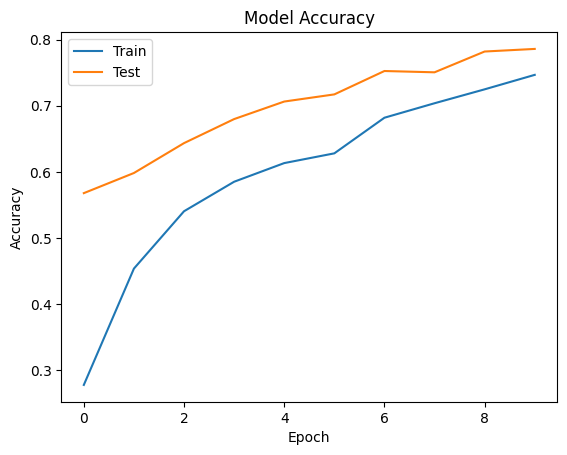

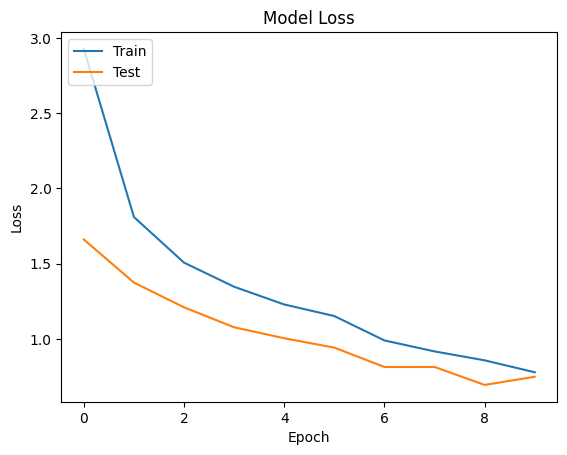

In [83]:
#Creating the model
model_VGG19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = model_VGG19.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(15, activation='softmax')(x)
model = Model(inputs=model_VGG19.input, outputs=predictions)

#Freezing the layers
for layer in model_VGG19.layers:
    layer.trainable = False

#Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Training the model
historyVGG19 = model.fit(train_ds, epochs=10, validation_data=val_ds)


Plotting VGG19 Model

In [ ]:
#Plotting the accuracy and loss
plt.plot(historyVGG19.history['accuracy'])
plt.plot(historyVGG19.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(historyVGG19.history['loss'])
plt.plot(historyVGG19.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Training ResNet50

75/75 [==============================] - 423s 5s/step - loss: 2.3953 - accuracy: 0.3102 - val_loss: 1036.5393 - val_accuracy: 0.1139


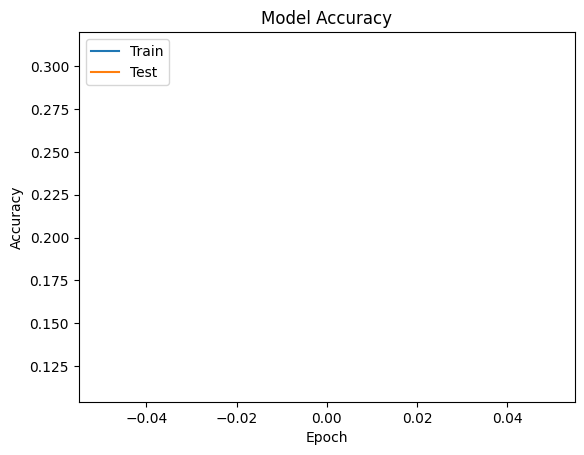

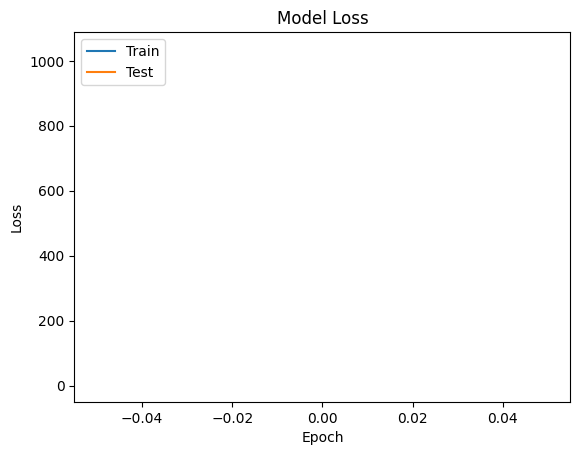

In [88]:
#Train a ResNet50 model
model_ResNet50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = model_ResNet50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(15, activation='softmax')(x)
model = Model(inputs=model_ResNet50.input, outputs=predictions)

#Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Training the model
historyResNet50 = model.fit(train_ds, epochs=1, validation_data=val_ds)

Plotting ResNet50 Model

In [89]:

#Plotting the accuracy and loss
plt.plot(historyResNet50.history['accuracy'])
plt.plot(historyResNet50.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(historyResNet50.history['loss'])
plt.plot(historyResNet50.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: name 'historyResNet50' is not defined

Training InceptionV3 Network

In [91]:
#Train a InceptionV3 model
model_InceptionV3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = model_InceptionV3.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(15, activation='softmax')(x)
model = Model(inputs=model_InceptionV3.input, outputs=predictions)

#Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Training the model
historyInceptionV3 = model.fit(train_ds, epochs=1, validation_data=val_ds)

75/75 [==============================] - 479s 6s/step - loss: 2.3702 - accuracy: 0.2576 - val_loss: 81676.2656 - val_accuracy: 0.0570


Plotting InceptionV3 Model

In [92]:
#Plotting the accuracy and loss
plt.plot(historyInceptionV3.history['accuracy'])
plt.plot(historyInceptionV3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(historyInceptionV3.history['loss'])
plt.plot(historyInceptionV3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: name 'historyInceptionV3' is not defined

In [ ]:
#Train a MobileNetV2 model
model_MobileNetV2 = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = model_MobileNetV2.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(15, activation='softmax')(x)
model = Model(inputs=model_MobileNetV2.input, outputs=predictions)

#Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Training the model
historyMobileNetV2 = model.fit(train_ds, epochs=1, validation_data=val_ds)

#Plotting the accuracy and loss
plt.plot(historyMobileNetV2.history['accuracy'])
plt.plot(historyMobileNetV2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(historyMobileNetV2.history['loss'])
plt.plot(historyMobileNetV2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#Train a DenseNet201 model
model_DenseNet201 = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = model_DenseNet201.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(15, activation='softmax')(x)
model = Model(inputs=model_DenseNet201.input, outputs=predictions)

#Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Training the model
historyDenseNet201 = model.fit(train_ds, epochs=1, validation_data=val_ds)

#Plotting the accuracy and loss
plt.plot(historyDenseNet201.history['accuracy'])
plt.plot(historyDenseNet201.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
